# Analysis of Allergic Rhinitis Gesture Dataset

##### Downloading and Navigating the Dataset

After downloading the [GestureSet Dataset](https://www.kaggle.com/datasets/tzamalisp/gestureset-dataset-for-human-gesture-recognition/data), navigate to the `GestureSet\allergic_rhinitis` directory. This directory contains all the relevant data files and subdirectories for the dataset.

The relevant publication can be found here: https://ieeexplore.ieee.org/document/10257296

*Please, install the `requirements.txt` file in order to run the Jupyter Notebook, and other dependencies.*

#### Setting Up Data Paths in Your Project

For setting up the data paths in your project, use the following directories:

1. **Training Data Path**:
   - Navigate to the `GestureSet\allergic_rhinitis\gestures_pure_ctrl` directory.
   - This directory should be used as the `TRAINING_DATA_PATH` in your project. It contains the primary dataset used for training models.

2. **Batch Evaluation Data Path**:
   - Navigate to the `GestureSet\allergic_rhinitis\performance_evaluation` directory.
   - Set this path as your `BATCH_EVALUATION_DATA_PATH`. This directory is  for evaluating the performance of your models in a pilot scenario from a batch of data. The aforementioned directory contains directory classes that model won't be trained with. Those should be ommited.


## Introduction

This notebook tutorial presents an end-to-end analysis of the Allergic Rhinitis Gesture Dataset, a collection of gesture data pertinent to allergic rhinitis. The data has been gathered using a wearable device, typically a smartwatch, which captures detailed movement information across eight distinct axes.

Append parent directory path 

In [1]:
import sys; sys.path.append('..')

Import Configuration Module 

In [2]:
from utils import load_config

Load configuration file

In [3]:
config = load_config("../config.yml")

Get Training Data Path

In [4]:
data_dir_path = config["TRAINING_DATA_PATH"]

##### Load Tabular-like data to a `Pandas DataFrame` with more than one dimension/column using `csv_loader`

In [5]:
from crossai.loader import csv_loader

df = csv_loader(path=data_dir_path)
df.head()

Loaded classes: ['null', '02a', 'rest', '02b', 'null_plus', '01c', '03a', '03b', '01d', '01a', '03c', '02c', '01b']


,instance,label,feature,data
0,1,null,acc_x_axis_g,"[-0.476, -0.854, -0.953, -0.767, -0.743, -0.89..."
1,1,null,acc_y_axis_g,"[0.264, 0.105, -0.058, -0.032, -0.04, 0.035, 0..."
2,1,null,acc_z_axis_g,"[1.221, 1.366, 1.183, 1.118, 1.314, 1.037, 0.9..."
3,1,null,gyr_x_axis_deg/s,"[-12.505, -30.988, -52.033, -47.031, -23.607, ..."
4,1,null,gyr_y_axis_deg/s,"[-18.544, -14.945, -2.501, 2.379, 5.246, 31.59..."


### Dataset Overview

The dataset is organized to capture various gestures associated with allergic rhinitis, each represented by a unique class label. Moreover, each instance of data is represented across six consecutive rows, each corresponding to a different measurement axis. For each instance in the dataset, we have the following six axes of data:

1. **Acceleration on the X-Axis (acc_x_axis_g)**: This column contains acceleration data along the x-axis, measured in gravity units (g). The data, like `[-0.04, -0.103, -0.16, -0.212, -0.251, -0.28, ...]`, represent the lateral motion or tilt.

2. **Acceleration on the Y-Axis (acc_y_axis_g)**: This column represents acceleration along the y-axis. The values, such as `[-0.999, -0.976, -0.975, -0.99, -0.989, -0.98,...]`, indicate vertical acceleration or tilt.

3. **Acceleration on the Z-Axis (acc_z_axis_g)**: Here, the data captures acceleration along the z-axis, with values like `[0.017, 0.055, 0.094, 0.128, 0.162, 0.19, 0.20...]` indicating forward or backward motion.

4. **Gyroscope Data on the X-Axis (gyr_x_axis_deg/s)**: This measures the rate of rotation around the x-axis in degrees per second. Values like `[-25.864, -14.457, -8.418, -8.296, -11.956, -1...]` show the angular velocity around this axis.

5. **Gyroscope Data on the Y-Axis (gyr_y_axis_deg/s)**: It captures the rotation rate around the y-axis, with data such as `[130.54, 139.69, 142.74, 140.483, 133.773, 123...]`.

6. **Gyroscope Data on the Z-Axis (gyr_z_axis_deg/s)**: This column records the gyroscope data for rotation around the z-axis, like `[-23.485, -21.472, -22.57, -27.328, -36.356, -...`.

Every six rows in the dataset correspond to a new instance, providing a six-axis view of the motion and orientation for that specific sample. For example, rows 0-5 represent all the axis data for instance 1, rows 6-11 for instance 2, and so on.

Number of Rows

In [6]:
print(df.shape[0])

2256


Number of instances (Division by 6 -> 6 axes)

In [7]:
print(df.shape[0]//6)

376


Distribution of Gesture Instances

In [8]:
print(df["label"].value_counts())

label
02a          318
02b          318
03b          240
03a          234
02c          228
01d          186
03c          168
01a          162
01c          156
01b          132
null          54
null_plus     48
rest          12
Name: count, dtype: int64


##### Create CrossAI Tabular Data Object to be Used for the Pipeline

In [9]:
from crossai.pipelines.tabular import Tabular

cai_tabular = Tabular(df)

Shape of `cai_tabular` Before Processing Pipelilne

In [10]:
cai_tabular.data.shape

(2256,)

##### Contruct Processing Pipeline

In this step, a CrossAI pipeline is created containing various functionalities of the data processing procedure:
* Data Engineering methods
* Scaling
* The `TimeMeasurementWrapper` which is CrossAI pipeline functionality that measures the time of execution of a 
pipeline step

In [11]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# crossai
from crossai.pipelines import TimeMeasurementWrapper
from crossai.pipelines.tabular import MagnitudeExtractor, AxisToModelShape, \
    MultiAxisSlidingWindow
from crossai.pipelines.motion import PureAccExtractor
from crossai.pipelines.preparation import Scaler

# This pipeline component extracts the magnitude from each axis/feature of a
# motion signal while measuring the time spent for this pipeline step
# Can be used for debugging purposes
ME = TimeMeasurementWrapper(
    MagnitudeExtractor(
        [[["acc_x_axis_g","acc_y_axis_g","acc_z_axis_g"], "acc_mag"],
        [["gyr_x_axis_deg/s","gyr_y_axis_deg/s","gyr_z_axis_deg/s"], "gyr_mag"]]
    )
)

# Extracts the pure acceleration from a motion signal for each axis, without 
# the time spent for this pipeline step
PAX = PureAccExtractor(
        Fs=100,
        acc_x="acc_x_axis_g",
        acc_y="acc_y_axis_g",
        acc_z="acc_z_axis_g"
    )

# performs sliding window of a motion signal for each axis
MSW = MultiAxisSlidingWindow(window_size=50, overlap=25)

# scales each motion signal at standard scale
SS = Scaler(StandardScaler())

# converts the axes of a motion signal to (instance, window_size, axes)
AXMS = AxisToModelShape()

### Dataset Enhancement with Magnitude Axes

In addition to the original six axes (three each for acceleration and gyroscope), the Allergic Rhinitis Gesture Dataset includes two key metrics:

- **Acceleration Magnitude (acc_mag)**: A calculated value summarizing the overall intensity of movement, derived from the x, y, and z acceleration axes.
- **Gyroscope Magnitude (gyr_mag)**: A similar composite measure for rotational movement, combining data from the three gyroscope axes.

These magnitudes provide a simplified view of motion intensity and rotational speed, complementing the detailed directional data from individual axes.

### Perform Pipeline

In [12]:
pipe = Pipeline([
    ("magex", ME),
    ("MSW", MSW),
    ("SS", SS),
    ("AXMS", AXMS),
])
pipe.fit_transform(cai_tabular)

Transformer MagnitudeExtractor took 0.00 seconds to fit.


Transformer MagnitudeExtractor took 0.39 seconds to transform.


In [13]:
print(cai_tabular.data.shape)

(42604, 50, 8)


#### Updated Data Structure Post-Pipeline Processing

After processing through the pipeline, the shape of our dataset has been transformed to (42604, 50, 8). This indicates that each instance in our dataset now represents a segment of 50 samples across all 8 axes.

### Data Preparation for training
Split Data on Train and Test Sets

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cai_tabular.data,
                                                    cai_tabular.labels,
                                                    test_size=0.2,
                                                    random_state=42
                                                )

In [15]:
X_train.shape, X_test.shape

((34083, 50, 8), (8521, 50, 8))

In [16]:
y_train.shape, y_test.shape

((34083,), (8521,))

Perform Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

### Create AI Model through CrossAI module

Disable TF debug warnings and numpy import

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np

Import Simple CNN1D Architecture

In [19]:
from crossai.ai.nn1d import CNN1D

cnn1d = CNN1D(
    input_shape=X_train.shape[1:],
    include_top=True,
    num_classes=np.unique(y_train).shape[0],
    classifier_activation="softmax",
    drp=.5,
    spatial=False,
    mc_inference=None
)

cnn1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            1600      
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 64)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 128)           49280     
                                                             

2023-11-29 15:57:13.228120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Callbacks for the training process

In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.00001)

Compile the Model

In [21]:
cnn1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Train the Model

In [22]:
history = cnn1d.fit(X_train, y_train,
                    epochs=100,
                    validation_split=.2,
                    verbose=0,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr]
                )

Evaluate the Model on Test Set

In [23]:
cnn1d.evaluate(X_test, y_test, return_dict=True)

267/267 [==============================] - 0s 2ms/step - loss: 0.2003 - accuracy: 0.9198


{'loss': 0.20028714835643768, 'accuracy': 0.9198451042175293}

Plot Learning Curves

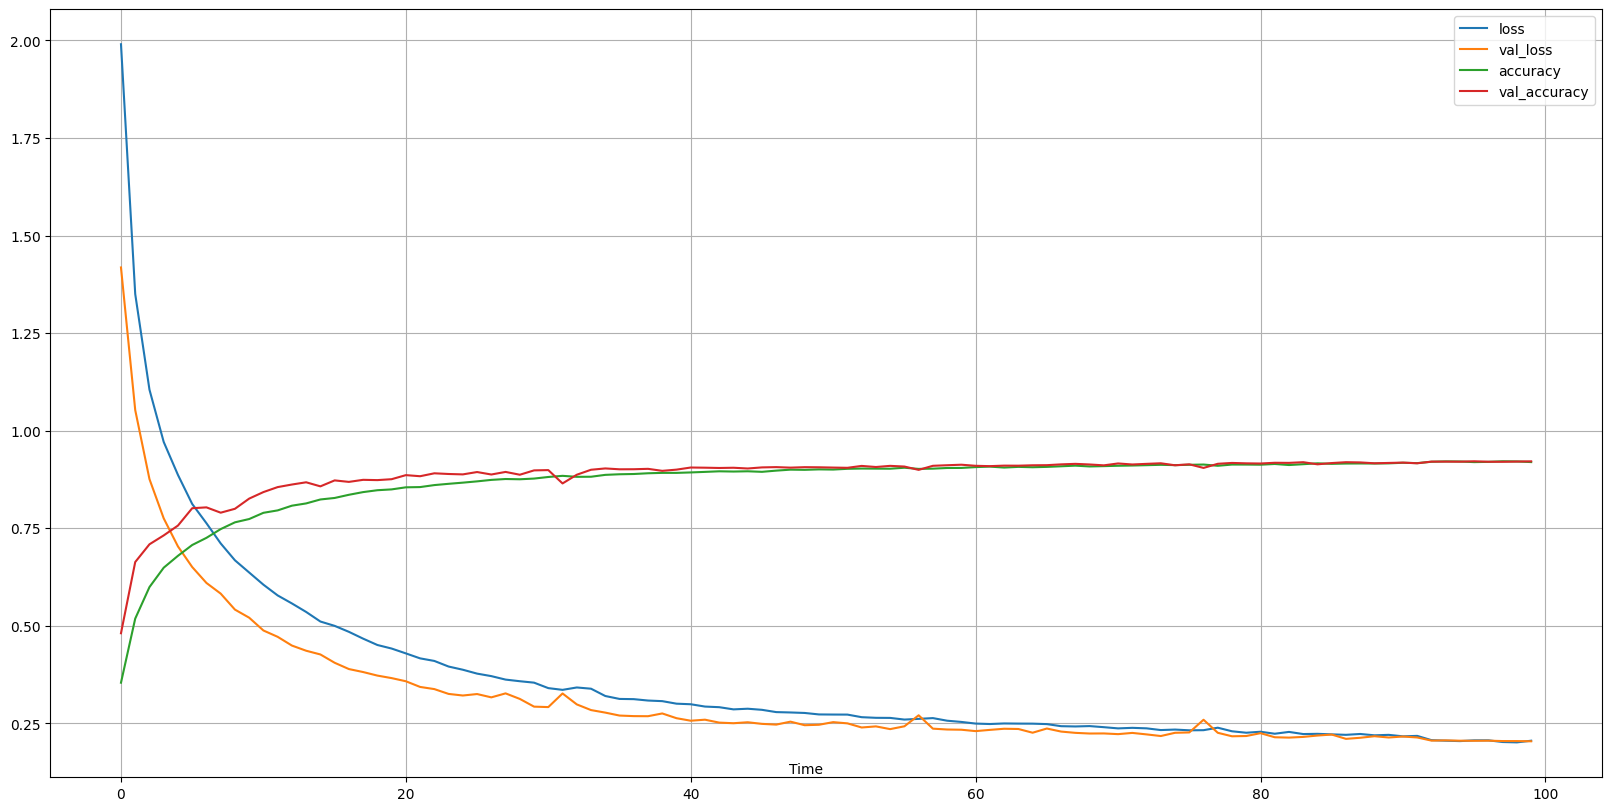

In [24]:
from crossai.visualization import plot_ts

plot_ts([
    history.history["loss"], history.history["val_loss"],
    history.history["accuracy"], history.history["val_accuracy"]
    ],
    labels=["loss", "val_loss", "accuracy", "val_accuracy"])

Confusion Matrix for more Insight

267/267 [==============================] - 0s 1ms/step


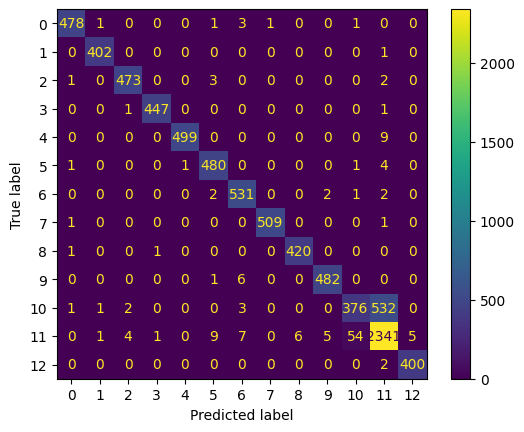

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(cnn1d.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot()

### Train a statistical model
Let's test the performance of a statistical model, like RandomForest

#### Prepare Data
Reducing the third dimension by flattening the timesteps for each axis

In [26]:
# flatten -> (instances, timesteps * axes)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

X_test_flatten.shape, X_test_flatten.shape

((8521, 400), (8521, 400))

Train a RandomForest classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train_flatten, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

#### Make predictions

In [28]:
y_pred_probs = model.predict_proba(X_test_flatten)
predictions = model.predict(X_test_flatten)

##### Plot Confusion Matrix

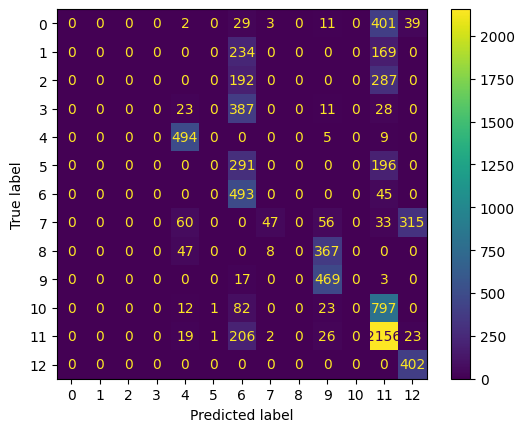

In [29]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

## Model Evaluation on Pilot Data

In [30]:
classes = list(le.classes_)
print(classes)

['01a', '01b', '01c', '01d', '02a', '02b', '02c', '03a', '03b', '03c', 'null', 'null_plus', 'rest']


Get path to pilot gesture instance

In [31]:
eval_instance_path = config["SINGLE_INSTANCE_EVALUATION_DATA_PATH"]

Extract and convert to json the information on the instance file for plotting purposes.

In [32]:
from utils import export_event_time_frame

export_event_time_frame(eval_instance_path)

Converted single file successfully.


Load again in Tabular-like format, but this time the pilot data

In [33]:
import crossai.performance.loader as cpl

# load evaluation object by providing the path to the folder
# containing the data, the baseline label and the label mapping
cai_eval_tab = cpl.csv_loader(eval_instance_path, classes, delimiter=',')

The region of interest, stored in `segments` list, is indicated by specific markers within the filename  
Plot the 3 axes of the motion signal  

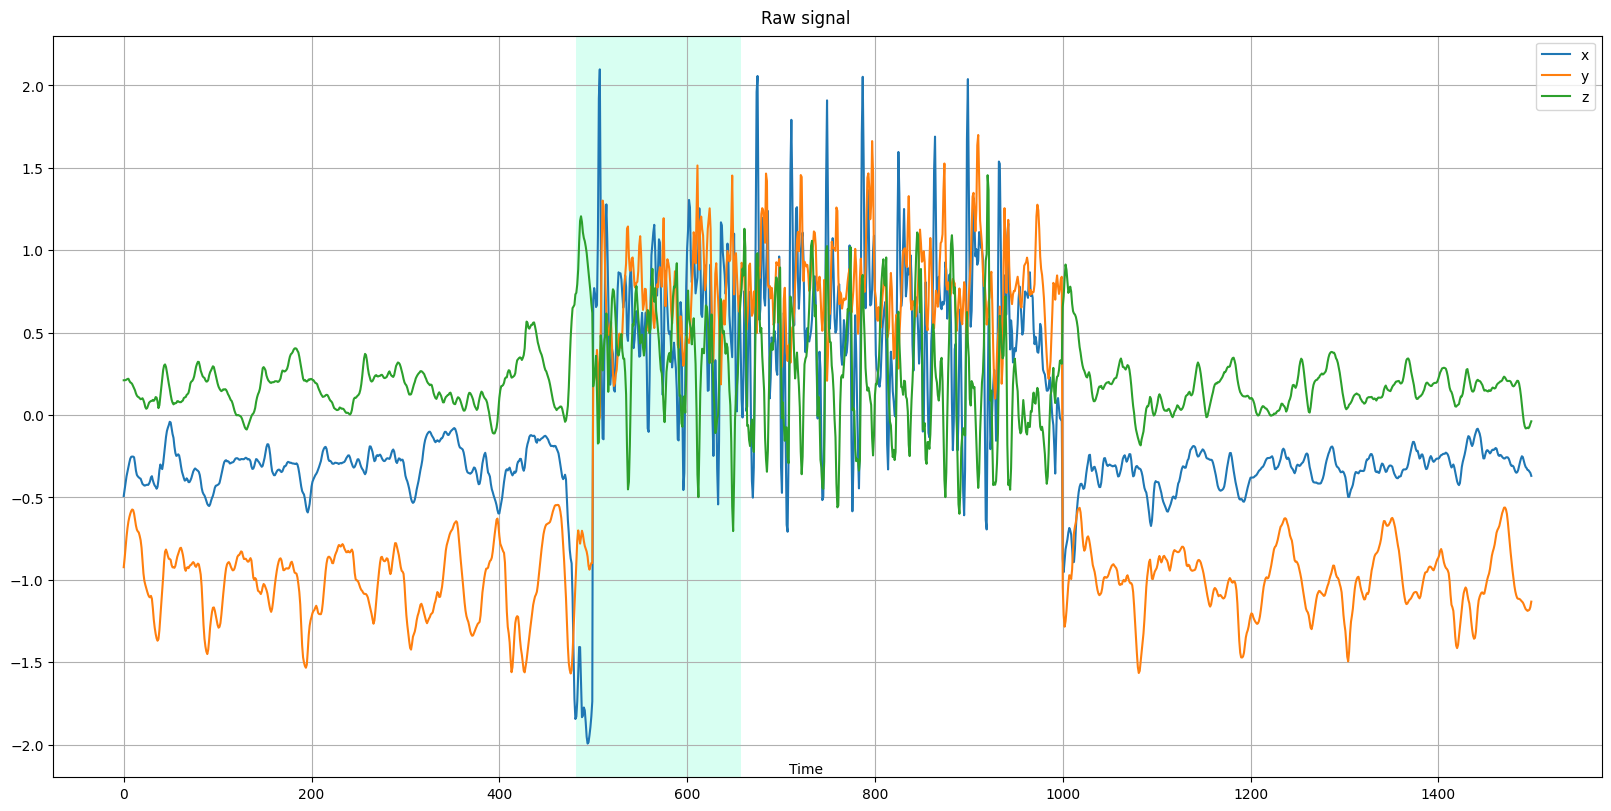

In [34]:
from crossai.visualization import plot_ts

segments = [482, 657]

plot_ts(
    data=cai_eval_tab.data[0:3],
    title="Raw signal",
    labels=["x","y","z"],
    segments=[[*segments, "aquamarine"]]
)

Perform similar processing as with train data by passing pilot instance through the same pipeline

In [35]:
pipe.transform(cai_eval_tab)

Transformer MagnitudeExtractor took 0.00 seconds to transform.


Check Shape Compatibility

In [36]:
print(cai_eval_tab.data.shape)

(58, 50, 8)


#### Perform Pilot Evaluation

In [37]:
from crossai.performance.pilot_evaluation import evaluate

results = evaluate(
    model=cnn1d,
    data=cai_eval_tab.data,
    labels=cai_eval_tab.labels,
    repeats=2
)

Count Insertions, deletions, substitutions and corrects

The publication in which the metrics for pilot data evaluation can be found is at the following link:
* https://ieeexplore.ieee.org/document/9881698

In [38]:
print("Insertions: ", results["insertions"])
print("Deletions: ", results["deletions"])
print("Substitutions: ", results["substitutions"])
print("Corrects: ", results["correct"])

Insertions:  2
Deletions:  0
Substitutions:  2
Corrects:  2


#### Plot section

Plots the probability of each instance being a specific gesture with respect to time

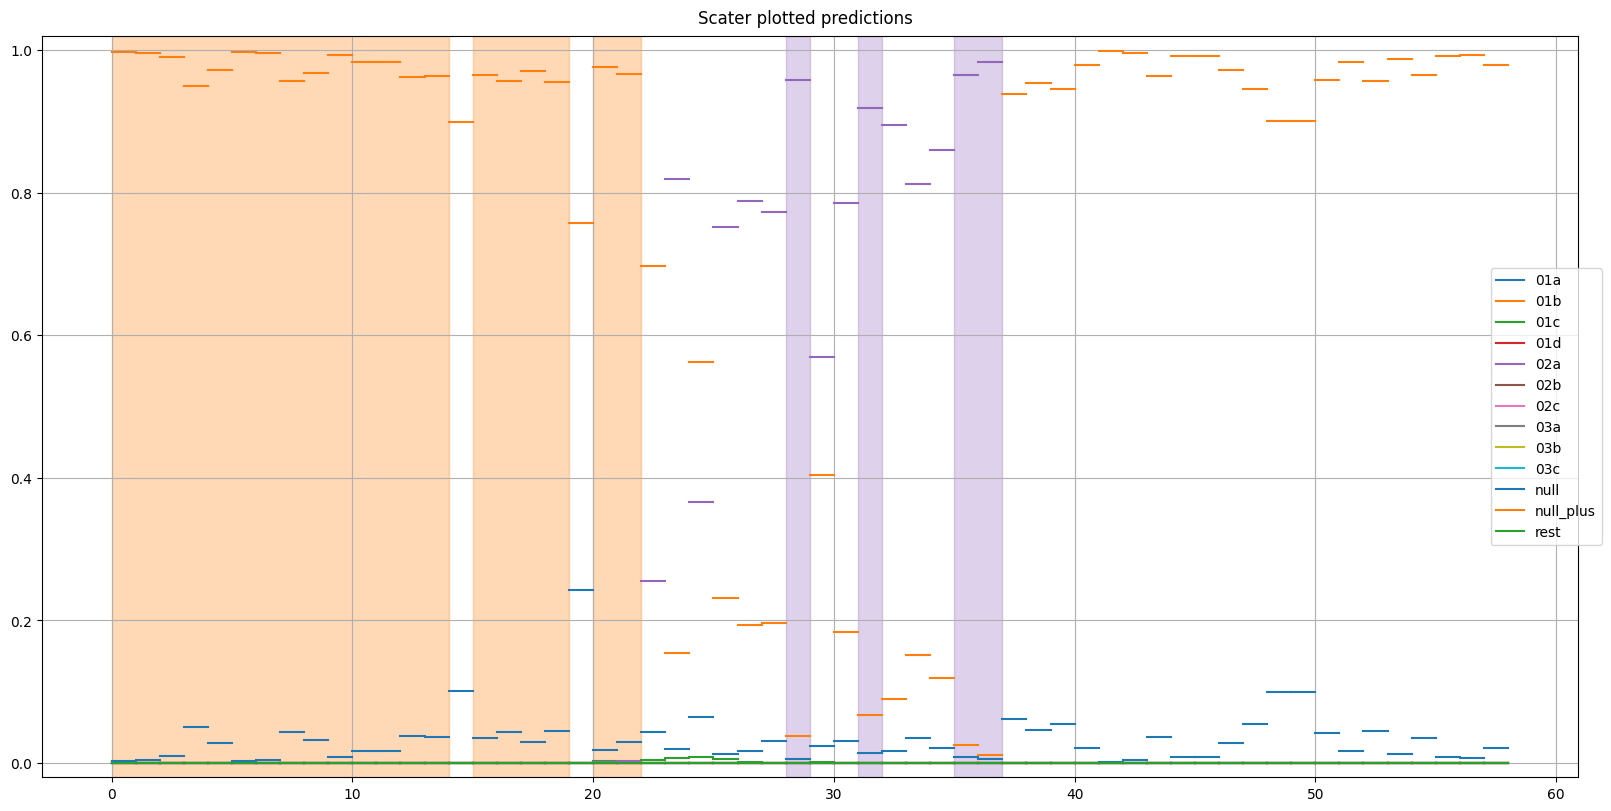

In [39]:
from crossai.visualization import plot_predictions

plot_predictions(results["mean_pred"],
                 title="Scater plotted predictions",
                 labels=list(le.classes_),
                 save_path=None,
                 show=True,
                 s=50,
                 color_threshold=0.9)

#### Batch pilot eval demo
Evaluate model on batch pilot data and save results.

**Be careful to delete the folders in pilot that contain classes that the model has not been trained with.**

Extract and convert to json the information on the instance file for plotting purposes.

In [40]:
batch_eval_path = config["BATCH_EVALUATION_DATA_PATH"]
export_event_time_frame(batch_eval_path)

Conversion completed successfully.


In [41]:
from crossai.performance.batch_pilot_evaluation import batch_evaluate

batch_evaluate(
    modality='tabular',
    model=cnn1d,
    folder=batch_eval_path,
    classes=classes,
    pipeline=pipe,
    save_path=config["EVALUATION_SAVE_PATH"],
    per_window=False,
    repeats=2
)

Transformer MagnitudeExtractor took 0.00 seconds to transform.
3/3 [==============================] - 0s 1ms/step


Transformer MagnitudeExtractor took 0.00 seconds to transform.
2/2 [==============================] - 0s 2ms/step
Transformer MagnitudeExtractor took 0.00 seconds to transform.
4/4 [==============================] - 0s 1ms/step


{'Num_of_Pilot': 3,
 'Total_insertions': 46,
 'Total_deletions': 0,
 'Total_substitutions': 2,
 'Total_correct': 4,
 'insertions': 15.333333333333334,
 'deletions': 0.0,
 'substitutions': 0.6666666666666666,
 'correct': 1.3333333333333333,
 'RER': 8.0,
 'detection_ratio': 0.6666666666666666,
 'reliability': 0.07999999999999999,
 'std': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'variance': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'entropy': [nan,
  nan,
  nan,
  0.0013887074775528437,
  0.0417337060885962,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.27333515403421077,
  0.22527005425504518,
  nan]}

The `EVALUATION_SAVE_PATH` is now organized with separate folders for each training class, each containing a collection of metrics in .json format for each training instance.